In [1]:
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
log_file = 'pymedgraphAPI.log'
csv_file = 'api_test220912.csv'

In [3]:
# read time tracking csv file from api request
df_csv = pd.read_csv(csv_file)
df_csv.head(3)

,iteration,search_term,number_articles,runtime,request_status
0,0,phenylketonuria,100,24.278141,200
1,0,hyperthyroidism,100,27.976333,200
2,0,epilepsy,100,30.181969,200


In [5]:
['phenylketonuria', 'hyperthyroidism', 'epilepsy']

['phenylketonuria', 'hyperthyroidism', 'epilepsy']

In [6]:
df_csv

,iteration,search_term,number_articles,runtime,request_status
0,0,phenylketonuria,100,24.278141,200
1,0,hyperthyroidism,100,27.976333,200
2,0,epilepsy,100,30.181969,200
3,0,phenylketonuria,250,64.979450,200
4,0,hyperthyroidism,250,58.313234,200
5,0,epilepsy,250,68.734326,200
6,0,phenylketonuria,500,112.195400,200
7,0,hyperthyroidism,500,83.125640,200
8,0,epilepsy,500,137.623100,200
9,1,phenylketonuria,100,35.566648,200


In [7]:
def df_from_log(file_path):
    # helper vars to build df
    log_times = list()
    terms = list()
    n_articles = list()
    iterations = list()
    log_message = list()
    # read logs
    new_term = False
    i = 0
    with open(log_file, 'r') as fh:
        for line in fh.readlines():
            if 'STARTING' in line:
                # append time
                log_times.append(datetime.strptime(line[:23], '%Y-%m-%d %H:%M:%S,%f'))
                # split logs message
                log_split = [re.sub(r'[\W_]+', '', i) for i in line.split("STARTING")[1].split(" ")]
                term = log_split[log_split.index('disease')+1]
                n = log_split[log_split.index('narticles')+1]
                # check if other iteration
                # append vals to lists
                terms.append(term)
                n_articles.append(n)
                log_message.append(line)
                i += 1
                iterations.append(i)
                new_term = True
            elif new_term:
                # append time
                log_times.append(datetime.strptime(line[:23], '%Y-%m-%d %H:%M:%S,%f'))
                terms.append(terms[-1])
                n_articles.append(n_articles[-1])
                log_message.append(line)
                iterations.append(i)
                
    return pd.DataFrame({
        'time': log_times,
        'term': terms,
        'n_articles': n_articles,
        'message': log_message,
        'iter': iterations
    })

In [8]:
def preprocess_logdf(df):
    # calculate time between logs
    df['time_delta'] = (df['time']-df['time'].shift()).apply(lambda x: x.total_seconds())
    # remove time from message
    df['log_text'] = df['message'].apply(lambda x: x[23:].split('--')[1])
    # set time delta from first log entry of request to 0
    df.loc[df['log_text'].str.contains("Got 'buildGraph' request."), 'time_delta'] = 0.0
    # save number of uploaded records to column and define shorten log text
    mask = df['log_text'].str.contains('Successfully uploaded data:')
    df.loc[mask, 'uploaded_records'] = df[mask]['log_text'].apply(lambda x: int(x.split(" ")[5].replace(',', '')))
    df.loc[mask, 'log_text'] = 'Successfully uploaded data'
    return df

In [9]:
# get df
df_log = df_from_log(log_file)
# and preprocess
ddf = preprocess_logdf(df_log)  

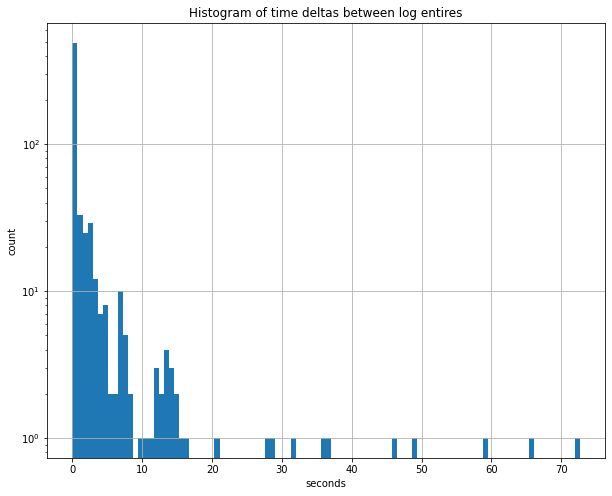

In [10]:
# plot time delta histo
fig, ax = plt.subplots(figsize=(10,8))
ddf.set_index('time')['time_delta'].hist(bins=100)
ax.set_yscale('log')
plt.title('Histogram of time deltas between log entires')
ax.set_xlabel('seconds')
ax.set_ylabel('count')
plt.show()

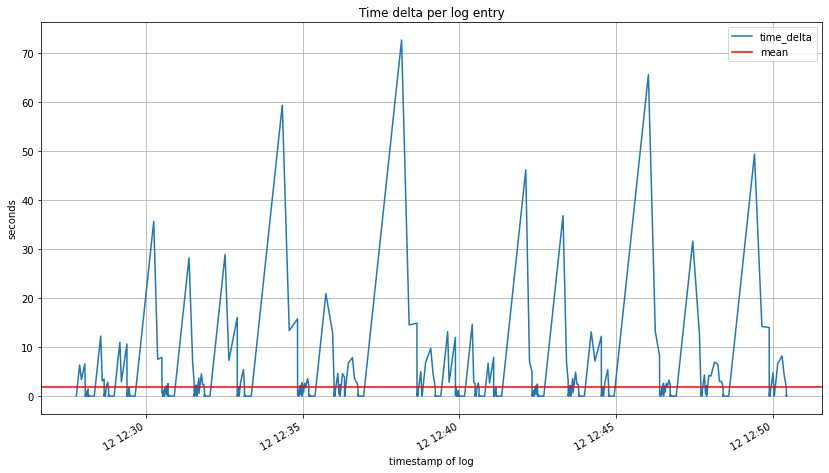

In [11]:
# plot line 
fig, ax = plt.subplots(figsize=(14,8))
ddf.set_index('time')['time_delta'].plot()
plt.title('Time delta per log entry')
ax.set_xlabel('timestamp of log')
ax.set_ylabel('seconds')
ax.axhline(y = ddf['time_delta'].mean(), color = 'r', linestyle = '-', label='mean')
plt.grid(True)
ax.legend()
plt.show()

In [12]:
ddf[ddf['time_delta']>0.5].groupby('log_text')['time_delta'].mean()

log_text
 127.0.0.1 - - [12/Sep/2022 12:36:20] "OPTIONS /searchTerms HTTP/1.1" 200 -\n     3.859000
 Successfully deleted existing graph.\n                                           1.183500
 Successfully extracted entities from abstracts.\n                                7.858167
 Successfully extracted gene data from UniProt.\n                                 0.746000
 Successfully extracted medGen data.\n                                            8.231889
 Successfully fetched pubmed articles.\n                                         30.678278
Successfully uploaded data                                                        2.332690
Name: time_delta, dtype: float64

In [276]:
df_slow = ddf[ddf['time_delta']>1].groupby('log_text').agg({
    'time_delta': 'mean',
    'term': 'count',
}).reset_index().rename(columns={'time_delta': 'time_mean', 'term': 'count'}).sort_values(by='time_mean', ascending=False)
df_slow

,log_text,time_mean,count
4,Successfully fetched pubmed articles.\n,30.678278,18
3,Successfully extracted medGen data.\n,8.231889,18
2,Successfully extracted entities from abstract...,7.858167,18
0,"127.0.0.1 - - [12/Sep/2022 12:36:20] ""OPTIONS...",3.859000,1
5,Successfully uploaded data,2.885851,94
1,Successfully deleted existing graph.\n,1.479000,2


In [273]:
def plot_logtype(df, log_text: str, plot_title: str, iter_marks: bool):
    # prep
    df_plot = df[df['log_text'].str.contains(log_text)].copy()
    df_plot['iter_label'] = df_plot['term'].str[0] + df_plot['n_articles']
    # plot line 
    fig, ax = plt.subplots(figsize=(14,8))
    df_plot.set_index('iter')['time_delta'].plot(linewidth=2)
    plt.title(plot_title)
    
    ax.set_ylabel('seconds')
    ax.axhline(y = df_plot['time_delta'].mean(), color = 'r', linestyle = '--', label='mean', linewidth=1)
    if iter_marks:
        # Get Unique continents
        color_labels = df_plot['iter_label'].unique()
        # List of colors in the color palettes
        rgb_values = sns.color_palette("Set2", len(color_labels))
        # Map continents to the colors
        color_map = dict(zip(color_labels, rgb_values))
        # Finally use the mapped values
        plt.scatter(df_plot['iter'], df_plot['time_delta'], c=df_plot['iter_label'].map(color_map), linewidth=5, alpha=1)
        ax.set_xticks(df_plot['iter'].values, df_plot['iter_label'].values)
    else:
        ax.set_xlabel('timestamp of log')
    plt.grid(True)
    ax.legend()
    plt.show()

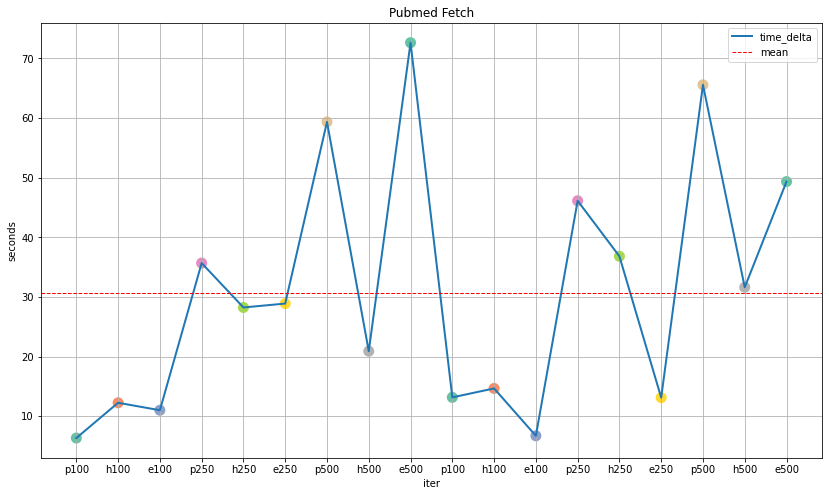

In [274]:
plot_logtype(ddf, 'Successfully fetched pubmed articles.', 'Pubmed Fetch', iter_marks=True)

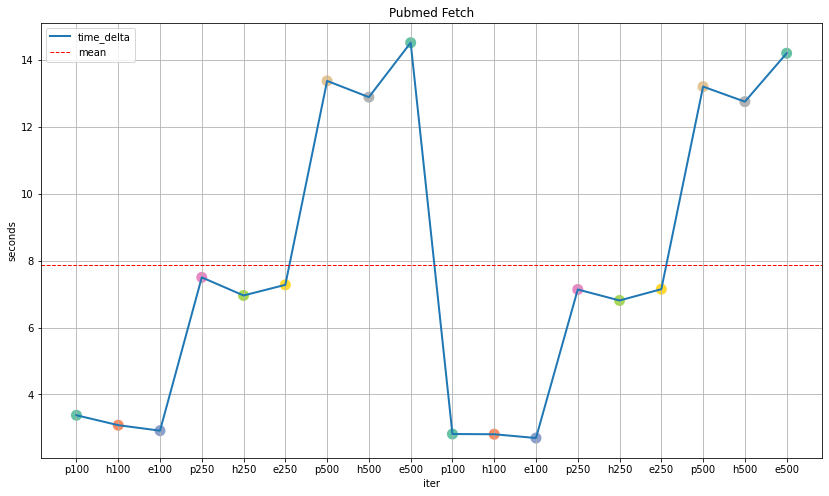

In [275]:
plot_logtype(ddf, 'extracted entities from abstract', 'Pubmed Fetch', iter_marks=True)

In [281]:
ddf

,time,term,n_articles,message,iter,time_delta,log_text,uploaded_records,iter_label
0,2022-09-12 12:27:46.939,phenylketonuria,100,"2022-09-12 12:27:46,939 INFO root build_graph ...",1,NaN,*** STARTING to process request '{'disease': ...,NaN,p100
1,2022-09-12 12:27:46.939,phenylketonuria,100,"2022-09-12 12:27:46,939 INFO root construct_me...",1,0.000,*** START processing pipelines for 'phenylket...,NaN,p100
2,2022-09-12 12:27:46.939,phenylketonuria,100,"2022-09-12 12:27:46,939 INFO root construct_me...",1,0.000,"With pipe config: {'n_articles': 100, 'delete...",NaN,p100
3,2022-09-12 12:27:53.268,phenylketonuria,100,"2022-09-12 12:27:53,268 INFO root construct_me...",1,6.329,Successfully fetched pubmed articles.\n,NaN,p100
4,2022-09-12 12:27:56.646,phenylketonuria,100,"2022-09-12 12:27:56,646 INFO root construct_me...",1,3.378,Successfully extracted entities from abstract...,NaN,p100
...,...,...,...,...,...,...,...,...,...
652,2022-09-12 12:50:26.193,epilepsy,500,"2022-09-12 12:50:26,193 INFO root insert_data ...",18,0.199,Successfully uploaded data,40.0,e500
653,2022-09-12 12:50:26.193,epilepsy,500,"2022-09-12 12:50:26,193 INFO root build_biomed...",18,0.000,Successfully uploaded node table 'Snomed'.\n,NaN,e500
654,2022-09-12 12:50:26.193,epilepsy,500,"2022-09-12 12:50:26,193 INFO root build_biomed...",18,0.000,Successfully uploaded node table 'ClinicalFea...,NaN,e500
655,2022-09-12 12:50:26.193,epilepsy,500,"2022-09-12 12:50:26,193 INFO root build_graph ...",18,0.000,Successfully uploaded graph with search term ...,NaN,e500


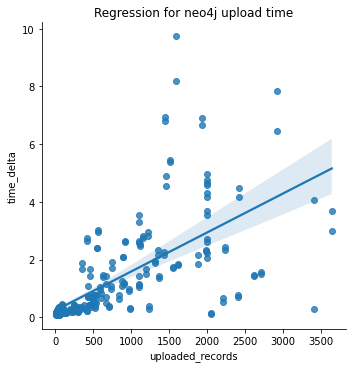

In [294]:
mask = ddf['log_text'].str.contains('Successfully uploaded data')
sns.lmplot(x='uploaded_records', y='time_delta', data=ddf[mask], fit_reg=True)
plt.title('Regression for neo4j upload time')
plt.show()

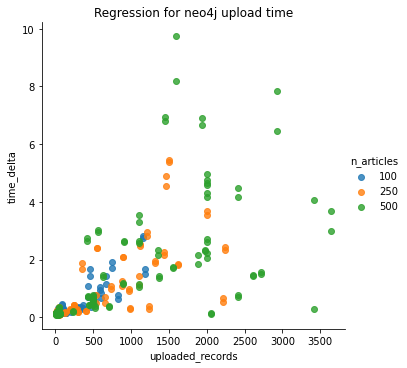

In [299]:
mask = ddf['log_text'].str.contains('Successfully uploaded data')
sns.lmplot(x='uploaded_records', y='time_delta', data=ddf[mask], hue='n_articles', fit_reg=False)
plt.title('Regression for neo4j upload time')
plt.show()